In [14]:
import os
import warnings
from functools import partialmethod

import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xqml
from tqdm import tqdm

from tools.common_functions import compute_theoretical_spectrum

In [15]:
tqdm.__init__ = partialmethod(tqdm.__init__, colour="green", ncols=120)
warnings.filterwarnings("ignore")

plt.rc("axes", labelsize=20, linewidth=1.5)
plt.rc("xtick", direction="in", labelsize=15, top=True)
plt.rc("ytick", direction="in", labelsize=15, right=True)

plt.rc("xtick.major", width=1.1, size=5)
plt.rc("ytick.major", width=1.1, size=5)

plt.rc("xtick.minor", width=1.1, size=3)
plt.rc("ytick.minor", width=1.1, size=3)

plt.rc("lines", linewidth=2)
plt.rc("legend", frameon=False, fontsize=15)
plt.rc("figure", dpi=100, autolayout=True, figsize=[10, 7])
plt.rc("savefig", dpi=150, bbox="tight")

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(
    color=[
        "red",
        "dodgerblue",
        "forestgreen",
        "goldenrod",
        "maroon",
        "cyan",
        "limegreen",
        "darkorange",
        "darkmagenta",
    ]
)

## Setting up relevant quantities

In [16]:
N_sims = 1000

fsky = 40
nside = 16
npix = hp.nside2npix(nside)

fwhm = 1.33333  # beam in [deg] (this corresponds to 80 arcmin beam)
spec = ["EE", "BB"]

lmax = 30
lmax_qml = 40
ell = np.arange(2, lmax + 1)
ell_full = np.arange(2, 501)
ell_factor = ell * (ell + 1) / (2 * np.pi)

# Grid of r values
r005s = np.linspace(-0.01, 0.02, 1201)

In [17]:
CURRENT_PATH = os.path.abspath("")

masks_folder = CURRENT_PATH + "/masks/"
sims_folder = CURRENT_PATH + "/sims/"
spectra_folder = CURRENT_PATH + "/spectra/"

print(CURRENT_PATH)

/home/ggalloni/Projects/LB_handson_2024


In [18]:
fiducial_spectrum = compute_theoretical_spectrum(lmax, r=0.0)
fiducial_spectrum_qml = compute_theoretical_spectrum(lmax_qml, r=0.0)
full_spectrum = compute_theoretical_spectrum(500, r=0.0)
print("Fiducial spectrum computed")
print(fiducial_spectrum.shape)

Fiducial spectrum computed
(31, 4)


Here we set the noise level in uK-arcmin. Out of it we need the pixel variance and 
the angular power spectrum.

In [19]:
noise_level = 10.0  # muK-arcmin

pixarea = hp.nside2pixarea(nside, degrees=True)
varperpix = (noise_level / 60.0) ** 2 / pixarea

nl = varperpix * 4.0 * np.pi / (12 * nside**2.0)

noise_spectrum = np.ones_like(ell) * nl

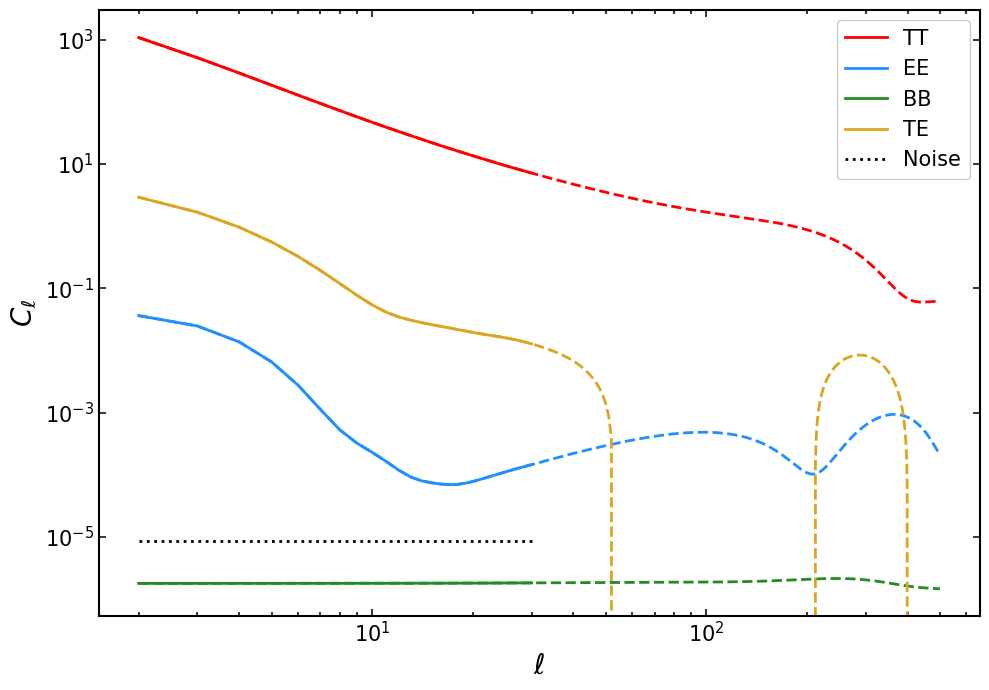

In [20]:
plt.plot(ell_full, full_spectrum[2:, 0], color="C0", ls="--")
plt.plot(ell_full, full_spectrum[2:, 1], color="C1", ls="--")
plt.plot(ell_full, full_spectrum[2:, 2], color="C2", ls="--")
plt.plot(ell_full, full_spectrum[2:, 3], color="C3", ls="--")

plt.plot(ell, fiducial_spectrum[2:, 0], label="TT", ls="-", color="C0")
plt.plot(ell, fiducial_spectrum[2:, 1], label="EE", ls="-", color="C1")
plt.plot(ell, fiducial_spectrum[2:, 2], label="BB", ls="-", color="C2")
plt.plot(ell, fiducial_spectrum[2:, 3], label="TE", ls="-", color="C3")

plt.plot(ell, noise_spectrum, label="Noise", ls=":", color="black")

plt.loglog()

plt.legend(loc="upper right", frameon=True, framealpha=1)

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.show()

## Producing the simulations

In [21]:
bl = hp.gauss_beam(np.deg2rad(fwhm), lmax=lmax, pol=True)
bl_qml = hp.gauss_beam(np.deg2rad(fwhm), lmax=lmax_qml, pol=True)
full_bl = hp.gauss_beam(np.deg2rad(fwhm), lmax=500, pol=True)
print(bl.shape)

(31, 4)


In [22]:
sims = np.zeros((N_sims, 3, npix))
CMB_sims = np.zeros((N_sims, 3, npix))
noise_sims = np.zeros((N_sims, 3, npix))
fullsky_spectra = np.zeros((N_sims, 6, lmax - 1))

for i in tqdm(range(N_sims), desc="Simulations".center(30)):
    alm = hp.synalm(full_spectrum.T, new=True, lmax=lmax, verbose=False)
    hp.almxfl(alm[0], full_bl[:, 0], inplace=True)
    hp.almxfl(alm[1], full_bl[:, 1], inplace=True)
    hp.almxfl(alm[2], full_bl[:, 2], inplace=True)

    mapp = hp.alm2map(alm, nside, pixwin=False, verbose=False)

    noise = np.zeros_like(mapp)

    noise[0] += np.random.normal(0, np.sqrt(varperpix / 2), npix)
    noise[1] += np.random.normal(0, np.sqrt(varperpix), npix)
    noise[2] += np.random.normal(0, np.sqrt(varperpix), npix)

    CMB_sims[i] = mapp
    noise_sims[i] = noise
    sims[i] = mapp + noise

    fullsky_spectra[i] = hp.anafast(sims[i], lmax=lmax, pol=True)[:, 2:]
print("Simulations done")
print(sims.shape)
print("Full-sky spectra computed")
print(fullsky_spectra.shape)

         Simulations          :   0%|                                                          | 0/1000 [00:00<?, ?it/s]

         Simulations          : 100%|██████████████████████████████████████████████| 1000/1000 [00:03<00:00, 305.59it/s]

Simulations done
(1000, 3, 3072)
Full-sky spectra computed
(1000, 6, 29)


In [ ]:
filename = "sims_80arcminbeam_1000sims.npy"
np.save(sims_folder + filename, sims)

filename = "CMB_sims_80arcminbeam_1000sims.npy"
np.save(sims_folder + filename, CMB_sims)

filename = "noise_sims_80arcminbeam_1000sims.npy"
np.save(sims_folder + filename, noise_sims)

In [24]:
filename = "fullsky_spectra_80arcminbeam_1000sims.npy"
np.save(spectra_folder + filename, fullsky_spectra)

fullsky_spectra = np.load(spectra_folder + filename)

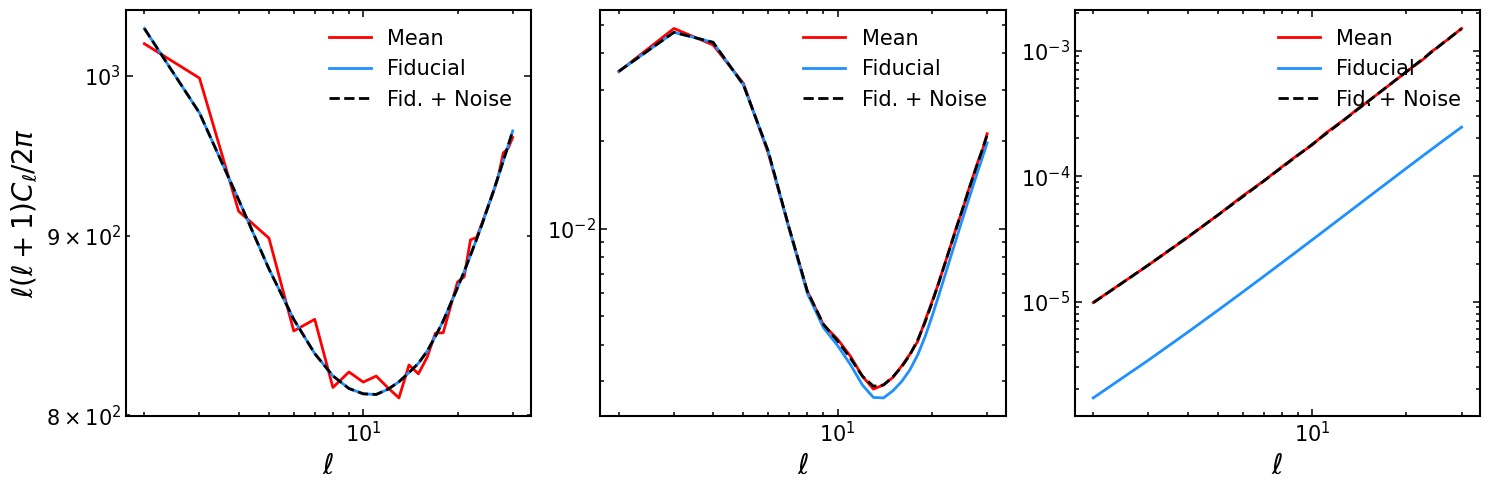

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(ell, ell_factor * np.mean(fullsky_spectra[:, 0], axis=0), label="Mean")
ax[0].plot(
    ell, ell_factor * fiducial_spectrum[2:, 0] * bl[2:, 0] ** 2, label="Fiducial"
)
ax[0].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 0] * bl[2:, 0] ** 2 + noise_spectrum / 2),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[1].plot(ell, ell_factor * np.mean(fullsky_spectra[:, 1], axis=0), label="Mean")
ax[1].plot(
    ell, ell_factor * fiducial_spectrum[2:, 1] * bl[2:, 1] ** 2, label="Fiducial"
)
ax[1].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 1] * bl[2:, 1] ** 2 + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[2].plot(ell, ell_factor * np.mean(fullsky_spectra[:, 2], axis=0), label="Mean")
ax[2].plot(
    ell, ell_factor * fiducial_spectrum[2:, 2] * bl[2:, 2] ** 2, label="Fiducial"
)
ax[2].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 2] * bl[2:, 2] ** 2 + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")
for i in range(3):
    ax[i].loglog()
    ax[i].legend(loc="upper right")
    ax[i].set_xlabel(r"$\ell$")

plt.show()

## Masking the sky

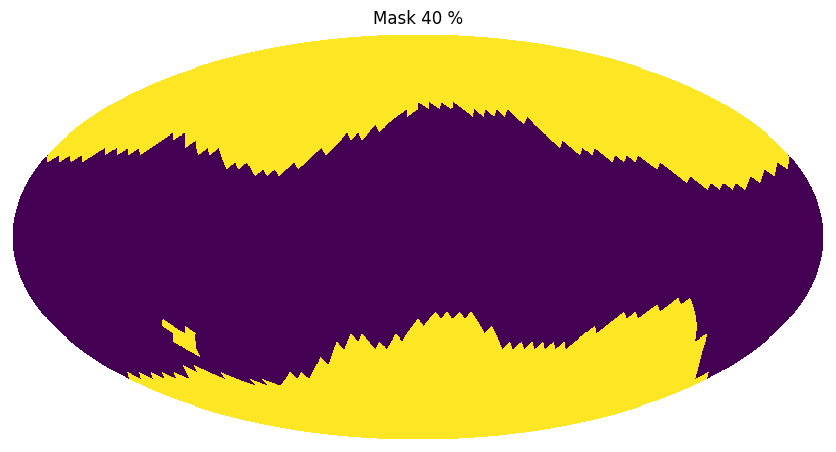

In [16]:
mask = hp.read_map(
    masks_folder + f"mask_T100_QU_galactic_fsky{str(fsky).zfill(3)}_ns0016.fits",
    verbose=False,
    field=2,
)

fsky_mask = np.mean(mask)

hp.mollview(mask, title=f"Mask {fsky_mask * 100:.0f} %", cbar=False)
plt.show()

In [ ]:
# print some relevant info
npix = int(sum(mask))
print(f"fsky={100 * fsky_mask} (npix={npix})")
toGB = 1024.0 * 1024.0 * 1024.0
emem = 8.0 * (npix * 2 * npix * 2) * (len(ell) * 2) / toGB
print(f"mem={emem} Gb")

fsky=40 % (npix=1240)
mem=2.7 Gb


In [18]:
# define parameters used later
stokes, spec, istokes, ispecs = xqml.xqml_utils.getstokes(spec=spec)
print(stokes, spec, istokes, ispecs)
nspec = len(spec)
nstoke = len(stokes)

['Q', 'U'] ['EE', 'BB'] [1, 2] [1, 2]


In [19]:
# ############## Generate White Noise ###############
varmap = np.ones(nstoke * npix) * varperpix
NoiseVar = np.diag(varmap)

In [20]:
bins = xqml.Bins.fromdeltal(2, lmax_qml, 1)

In [21]:
esti = xqml.xQML(
    mask,
    bins,
    fiducial_spectrum_qml.T,
    NA=NoiseVar,
    NB=NoiseVar,
    lmax=lmax_qml,
    bell=bl_qml[:, 2],
    fwhm=fwhm,
    spec=spec,
    pixwin=False,
    verbose=True,
)

xQML
spec:  ['EE', 'BB']
nbin:  39
Memset: 3.57 Gb (2,39,2,1240)
Construct Pl (npix=1240): 3.1 sec
Construct El (nl=78): 39.3 sec
Construct Wll (nl=78): 83.6 sec
Construct estimator: 124.7 sec


In [ ]:
cutsky_spectra = np.zeros((N_sims, 2, lmax - 1))

bool_mask = mask > 0

for i in tqdm(range(N_sims), desc="Cut sky".center(30)):
    mapp = sims[i][istokes][:, bool_mask]
    cutsky_spectra[i] = esti.get_spectra(mapp, mapp)[:, : lmax - 1]

           Cut sky            : 100%|███████████████████████████████████████████████| 1000/1000 [02:09<00:00,  7.70it/s]


In [ ]:
CMB_cutsky_spectra = np.zeros((N_sims, 2, lmax - 1))

bool_mask = mask > 0

for i in tqdm(range(N_sims), desc="Cut sky".center(30)):
    mapp = CMB_sims[i][istokes][:, bool_mask]
    CMB_cutsky_spectra[i] = esti.get_spectra(mapp, mapp)[:, : lmax - 1]

           Cut sky            : 100%|███████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.10it/s]


In [ ]:
noise_cutsky_spectra = np.zeros((N_sims, 2, lmax - 1))

bool_mask = mask > 0

for i in tqdm(range(N_sims), desc="Cut sky".center(30)):
    mapp = noise_sims[i][istokes][:, bool_mask]
    noise_cutsky_spectra[i] = esti.get_spectra(mapp, mapp)[:, : lmax - 1]

           Cut sky            : 100%|███████████████████████████████████████████████| 1000/1000 [02:55<00:00,  5.71it/s]


In [27]:
filename = f"cutsky_spectra_{fsky}fsky_80arcminbeam_1000sims.npy"

np.save(spectra_folder + filename, cutsky_spectra)

cutsky_spectra = np.load(spectra_folder + filename)

filename = f"CMB_cutsky_spectra_{fsky}fsky_80arcminbeam_1000sims.npy"

np.save(spectra_folder + filename, CMB_cutsky_spectra)

CMB_cutsky_spectra = np.load(spectra_folder + filename)

filename = f"noise_cutsky_spectra_{fsky}fsky_80arcminbeam_1000sims.npy"

np.save(spectra_folder + filename, noise_cutsky_spectra)

noise_cutsky_spectra = np.load(spectra_folder + filename)

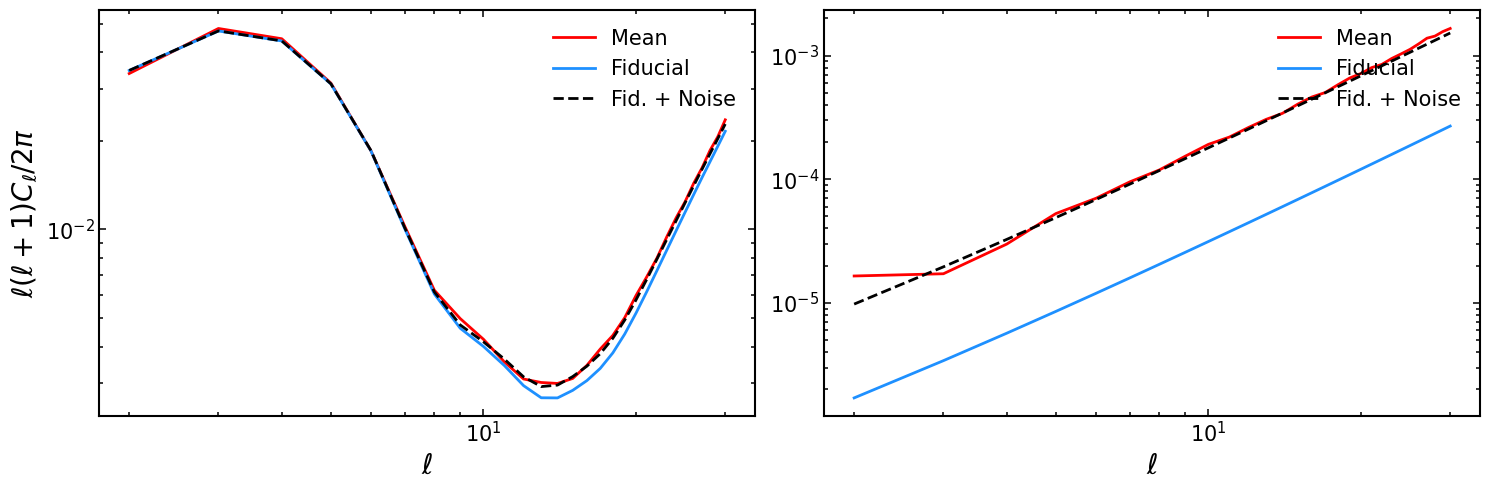

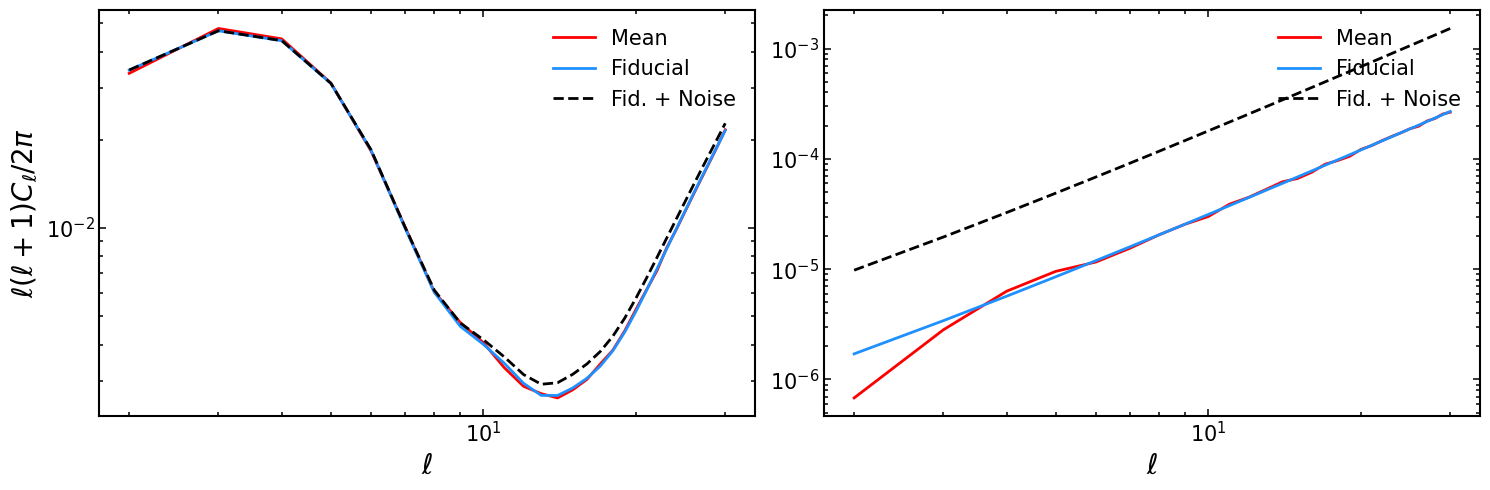

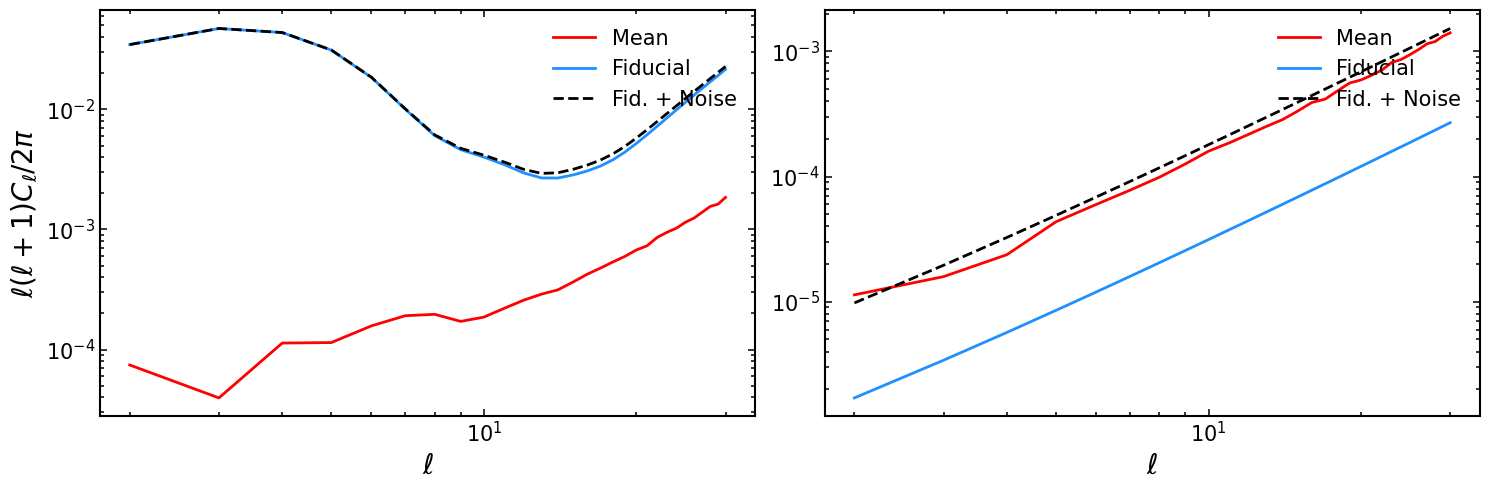

: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ell, ell_factor * np.mean(cutsky_spectra[:, 0], axis=0), label="Mean")
ax[0].plot(ell, ell_factor * fiducial_spectrum[2:, 1], label="Fiducial")
ax[0].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 1] + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[1].plot(ell, ell_factor * np.mean(cutsky_spectra[:, 1], axis=0), label="Mean")
ax[1].plot(ell, ell_factor * fiducial_spectrum[2:, 2], label="Fiducial")
ax[1].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 2] + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")
for i in range(2):
    ax[i].loglog()
    ax[i].legend(loc="upper right")
    ax[i].set_xlabel(r"$\ell$")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ell, ell_factor * np.mean(CMB_cutsky_spectra[:, 0], axis=0), label="Mean")
ax[0].plot(ell, ell_factor * fiducial_spectrum[2:, 1], label="Fiducial")
ax[0].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 1] + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[1].plot(ell, ell_factor * np.mean(CMB_cutsky_spectra[:, 1], axis=0), label="Mean")
ax[1].plot(ell, ell_factor * fiducial_spectrum[2:, 2], label="Fiducial")
ax[1].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 2] + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")
for i in range(2):
    ax[i].loglog()
    ax[i].legend(loc="upper right")
    ax[i].set_xlabel(r"$\ell$")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ell, ell_factor * np.mean(noise_cutsky_spectra[:, 0], axis=0), label="Mean")
ax[0].plot(ell, ell_factor * fiducial_spectrum[2:, 1], label="Fiducial")
ax[0].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 1] + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[1].plot(ell, ell_factor * np.mean(noise_cutsky_spectra[:, 1], axis=0), label="Mean")
ax[1].plot(ell, ell_factor * fiducial_spectrum[2:, 2], label="Fiducial")
ax[1].plot(
    ell,
    ell_factor * (fiducial_spectrum[2:, 2] + noise_spectrum),
    label="Fid. + Noise",
    ls="--",
    color="black",
)

ax[0].set_ylabel(r"$\ell(\ell+1)C_{\ell}/2\pi$")
for i in range(2):
    ax[i].loglog()
    ax[i].legend(loc="upper right")
    ax[i].set_xlabel(r"$\ell$")

plt.show()